In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import head_direction as hd
import expipe
import exdir
import os
import sys
import pathlib
import numpy as np
import numpy.ma as ma
import scipy
import tqdm
import pandas as pd

sys.path.append('../ca2-mec') if '../ca2-mec' not in sys.path else None 
import dataloader as dl
from utils import *

In [3]:
project = expipe.get_project(dl.project_path())
project.actions

### Load spike trains for selected actions

In [4]:
lim = [0,1200] # limit recording times - in seconds
include_actions = ['011-120321-2', '011-120321-3', '011-120321-4', '011-120321-5', '011-120321-6'] # choose actions to include

spikes = []
tracking = {}
for action_id in include_actions:
    spikes += dl.load_spiketrains(action_id, lim=lim, identify_neurons=True)
    tracking[action_id] = dl.load_tracking(action_id, lim=lim) # only get positions
    
spikes = dl.correct_mua(spikes, only_good_mua=True)
    
print("Total number of units:", len(spikes))

Total number of units: 136


### Example spikes, tracking and ratemap

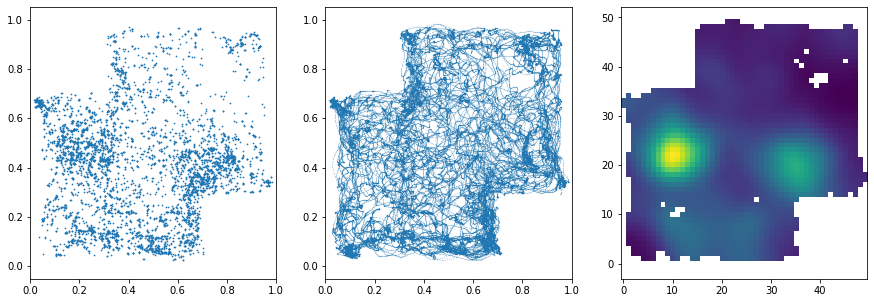

In [5]:
idx = 4
spike_train, r, t = spikes[idx], tracking[spikes[idx].annotations["action_id"]][...,:2], tracking[spikes[idx].annotations["action_id"]][...,2]
f = scipy.interpolate.interp1d(t, r.T, kind='linear')
spike_positions = f(spike_train.times)

def ratemap_func(x,y,t,spike_train,box_size=[1.0,1.0],bin_size=0.02,smoothing = 0.05,mask_zero_occupancy=True):
    smap = sp.SpatialMap(y,x,t,np.array(spike_train.times), box_size, bin_size)
    return smap.rate_map(smoothing,mask_zero_occupancy)

fig, axs = plt.subplots(ncols=3,figsize=(15,5))
axs[0].scatter(*spike_positions,s=0.5)
axs[1].scatter(*r.T,s=0.01)
axs[2].imshow(ratemap_func(*r.T,t,spike_train),origin='lower')
[ax.axis('equal') for ax in axs]
_=[ax.axis([0,1,0,1]) for ax in axs[:-1]]

In [6]:
# Choose which two trials to cross correlate
trials = ['t2', 't3']

# remove spike_trains not in trials
spikes = [spike_train for spike_train in spikes if spike_train.annotations["trial_id"] in trials]
# remove spike_trains not persistent between trials
spikes = [spike_train for spike_train in spikes if set(spike_train.annotations["persistent_trials"]) & set(trials) == set(trials)]
len(spikes)

40

In [7]:
# Split spikes on trial tag
spikes1 = [spike_train for spike_train in spikes if spike_train.annotations["trial_id"] == trials[0]]
spikes2 = [spike_train for spike_train in spikes if spike_train.annotations["trial_id"] == trials[1]]

# Sort spikes2 such that spikes1[idx].annotations["unit_id"] == spikes2[idx].annotations["unit_id"] for all idxs.
# In other words, the same unit at the same idx in the two lists (trials).
sort_keys = {spike_train.annotations["unit_id"] : idx for spike_train, idx in zip(spikes1,range(len(spikes1)))}
spikes2 = sorted(spikes2, key=lambda spike_train: sort_keys[spike_train.annotations["unit_id"]])
len(spikes1), len(spikes2)

(20, 20)

In [8]:
crosscorrelation = {'rot0': [], 'rot180': []}
for spike_train1, spike_train2 in zip(spikes1, spikes2):
    action_id1, action_id2 = spike_train1.annotations["action_id"], spike_train2.annotations["action_id"]
    ratemap1 = ratemap_func(*tracking[action_id1].T[:3],spike_train1)
    ratemap2 = ratemap_func(*tracking[action_id2].T[:3],spike_train2)
    crosscorrelation['rot0'].append(nancorrcoef(ratemap1, ratemap2))
    crosscorrelation['rot180'].append(nancorrcoef(ratemap1[::-1,::-1], ratemap2))

### Plot (violin) and summarise statistics (Mann-U)

rot0 vs rot180: MannwhitneyuResult(statistic=384.0, pvalue=6.916583488077116e-07)


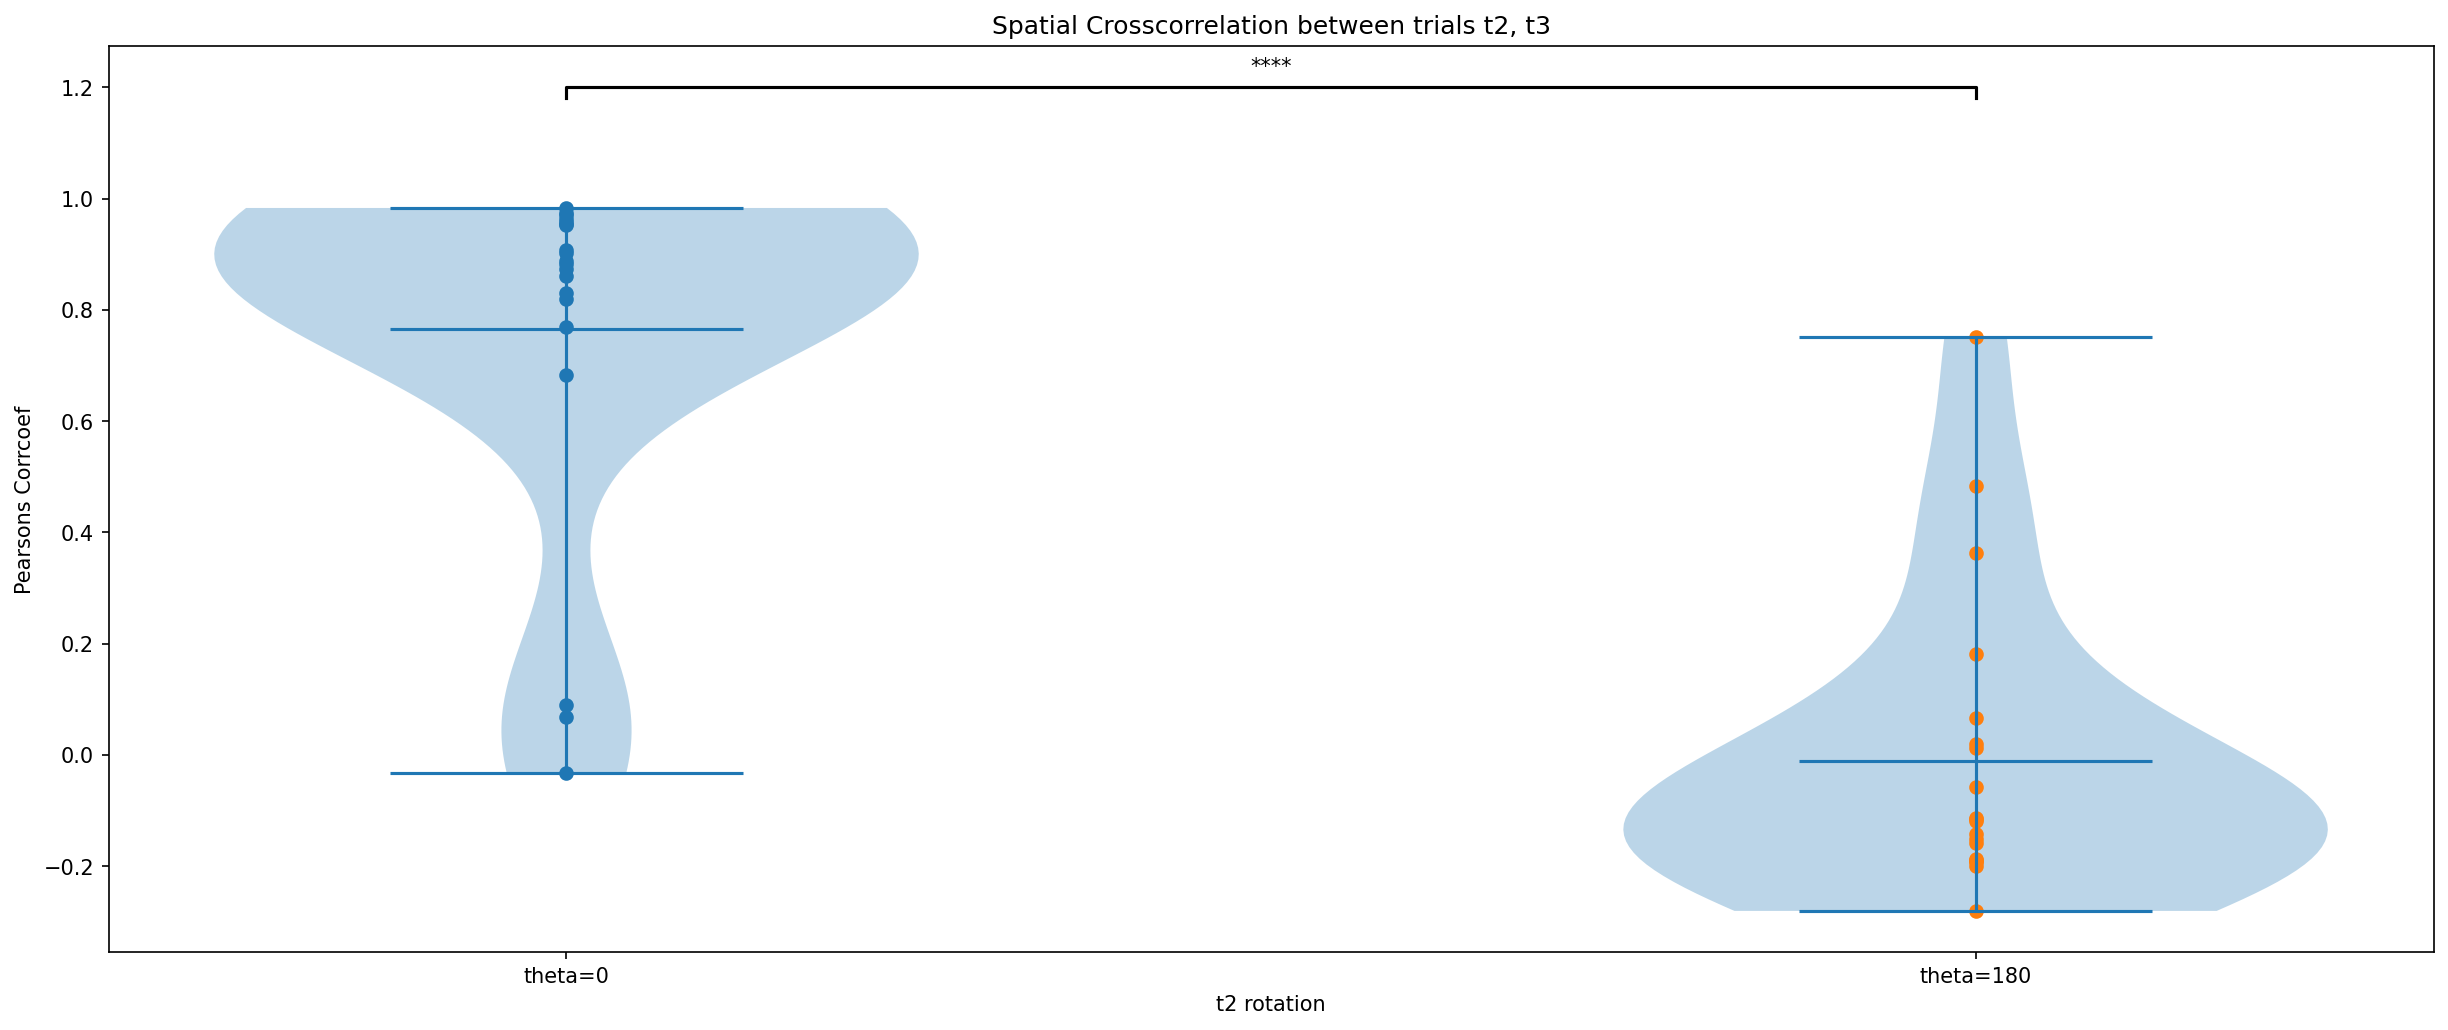

In [9]:
plt.rcParams.update({'figure.dpi': 150, 'legend.frameon': False})
# sns.set_style('white', {'legend.frameon': False})
palette = {'setosa': '#7fc97f', 'versicolor': '#beaed4', 'virginica': '#fdc086'}

fig, ax = plt.subplots(figsize=(20,8))
ax.violinplot(crosscorrelation.values(), showmeans=True)
#plt.xticks(rotation=45)

# --- plot formatting ---
# add trial labels to x-axes ticks
labels = ['theta=0','theta=180']
ticks_locs = np.arange(1, len(labels) + 1)
ax.set_xticks(ticks_locs)
ax.set_xticklabels(labels)

# --- Plot data points in the violin ---
for xtick, stabs in zip(ticks_locs, crosscorrelation.values()):
    ax.scatter(np.ones(len(stabs))*xtick, stabs)

# set axes and title labels
ax.set_title('Spatial Crosscorrelation between trials {}, {}'.format(*trials))
ax.set_ylabel('Pearsons Corrcoef')
ax.set_xlabel('{} rotation'.format(trials[0]))

def plot_significance(pvalue, x = [0, 1], y=1.2, h=0.02):
    # significance
    if pvalue < 0.0001:
        significance = "****"
    elif pvalue < 0.001:
        significance = "***"
    elif pvalue < 0.01:
        significance = "**"
    elif pvalue < 0.05:
        significance = "*"
    else:
        significance = "ns"

    x1, x2 = x
    plt.plot([x1, x1, x2, x2], [y - h, y, y, y - h], c='k')
    plt.text((x1 + x2) / 2, y + h, significance, ha='center', va='bottom')

    
for i, t_id in enumerate(crosscorrelation):
    if i == 0:
        baseline = t_id
        continue
        
    mw = scipy.stats.mannwhitneyu(crosscorrelation[baseline], crosscorrelation[t_id], alternative='two-sided')
    print(baseline + " vs " + t_id + ":", mw)
    plot_significance(mw.pvalue, [1,i+1], y = 1.1 + (i)*0.1)

plt.savefig('./plots/{}-cross-trial-spatial-stability.pdf'.format(trials[0]+trials[1]))

### Plot SORTED (wrt. correlations values) ratemaps
In other words, plotting the ratemaps of units with the correlation values in the violin plot arranged from top-to-bottom. Hence, the points at the top of the violin plot will correspond to the first ratemaps displayed, while the latter points will correspond to the latter ratemaps plotted.

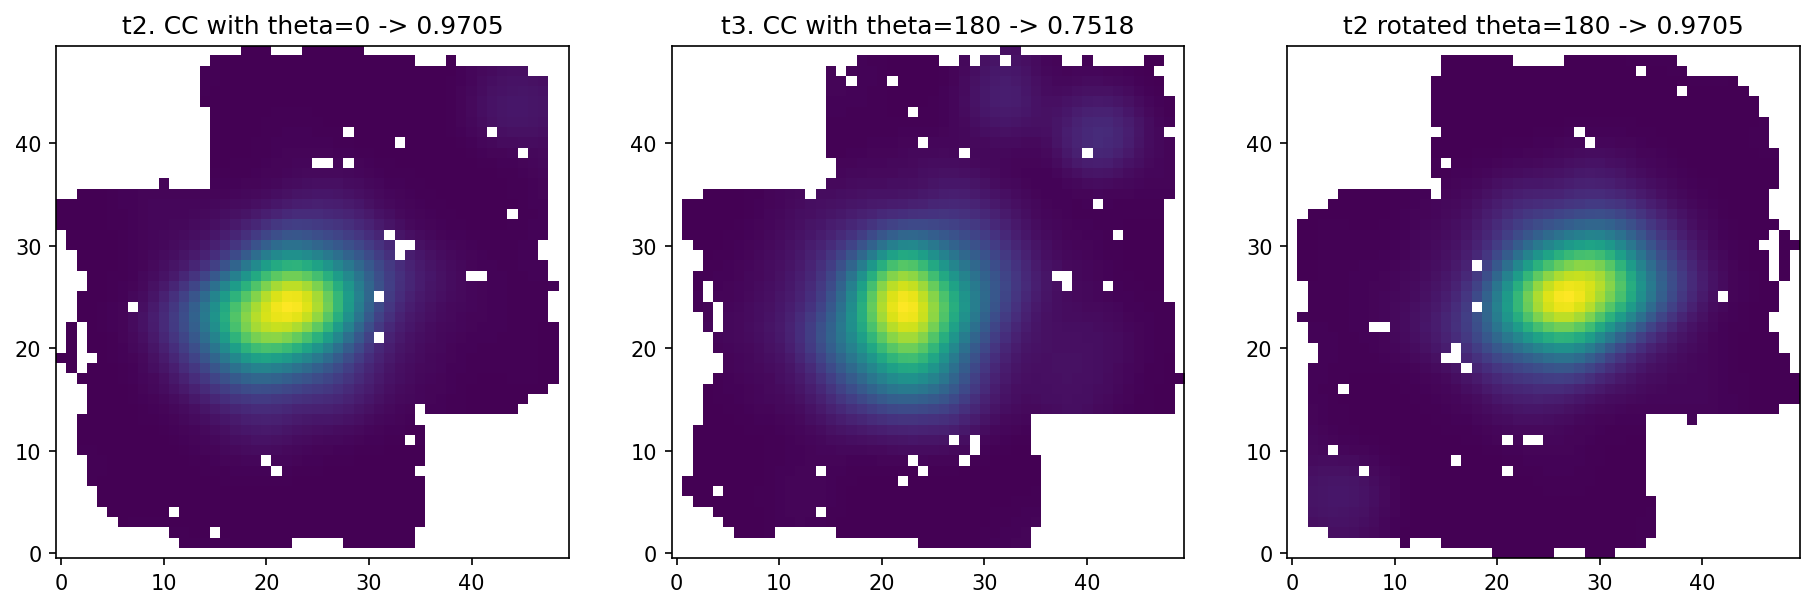

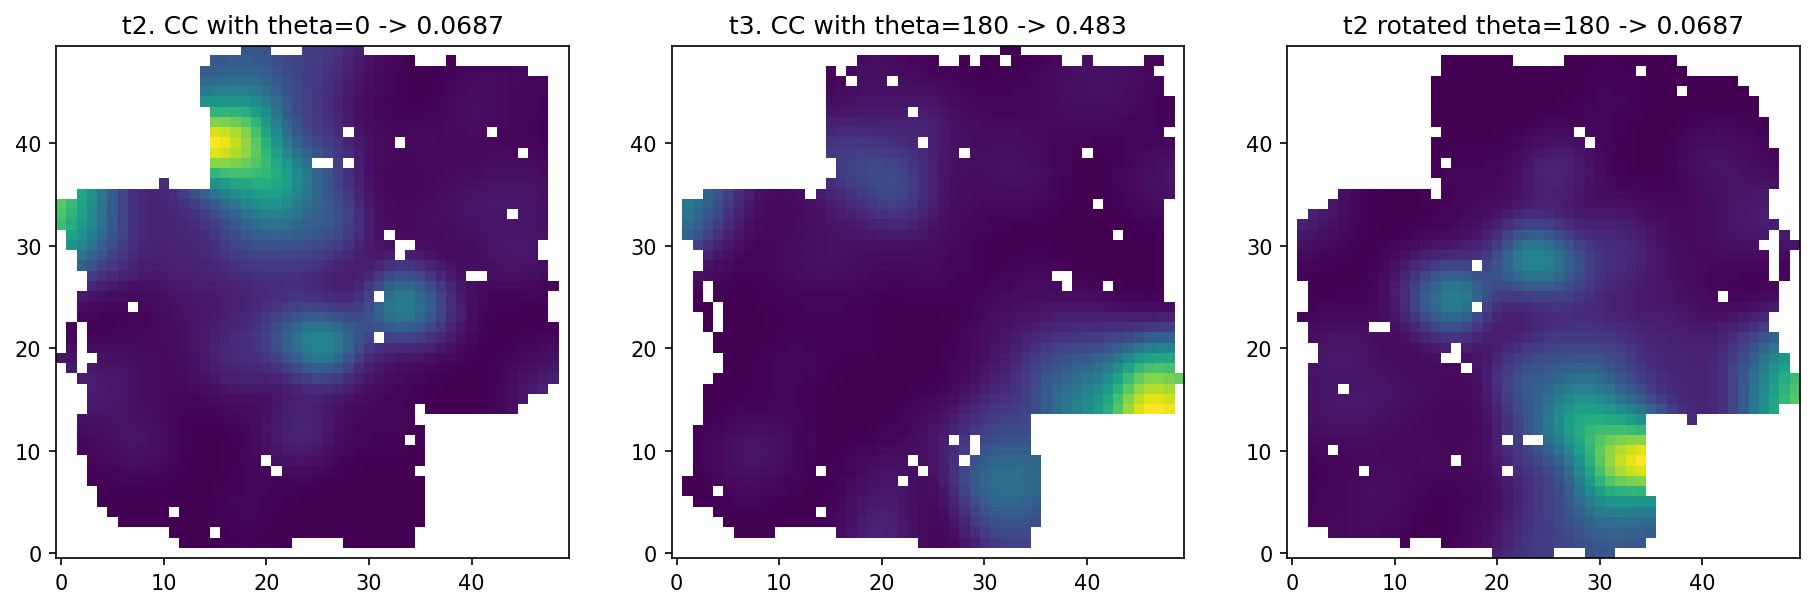

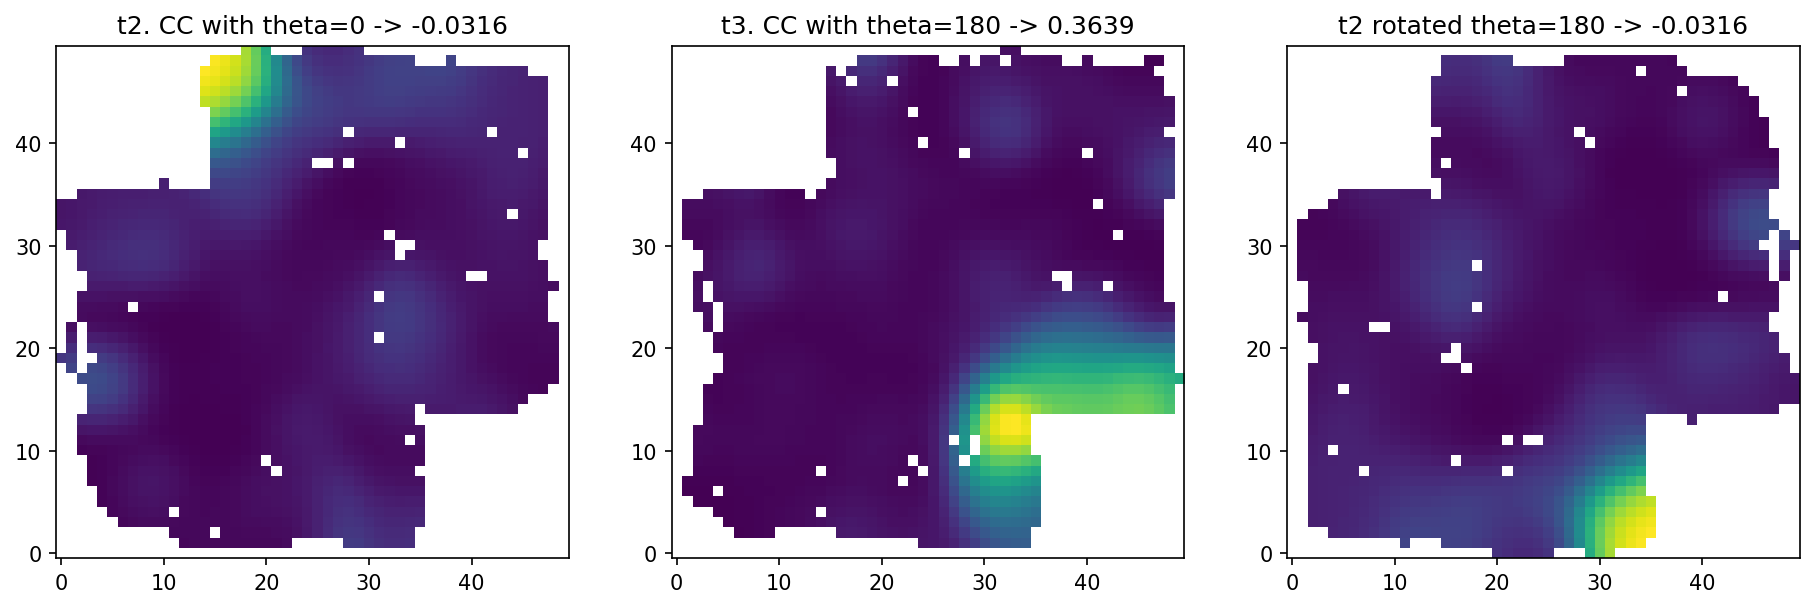

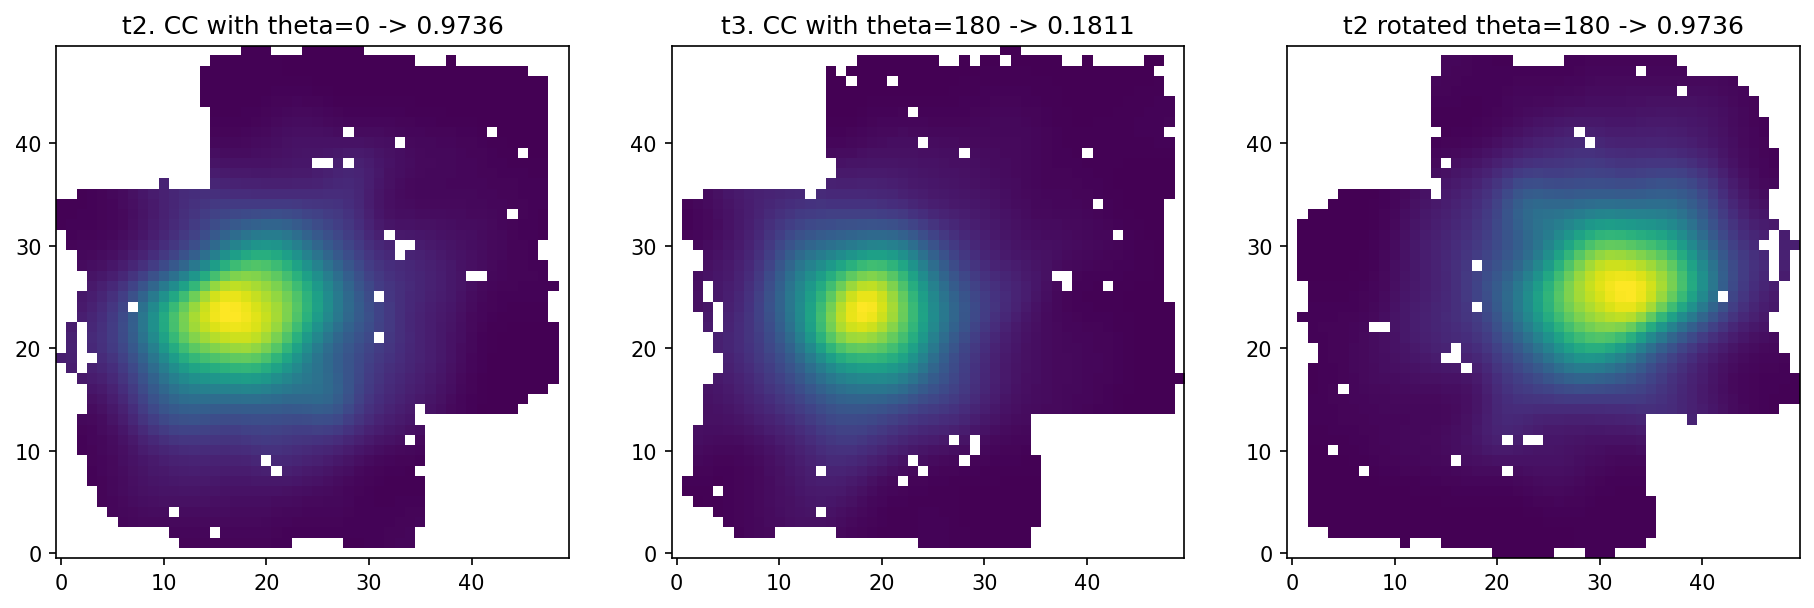

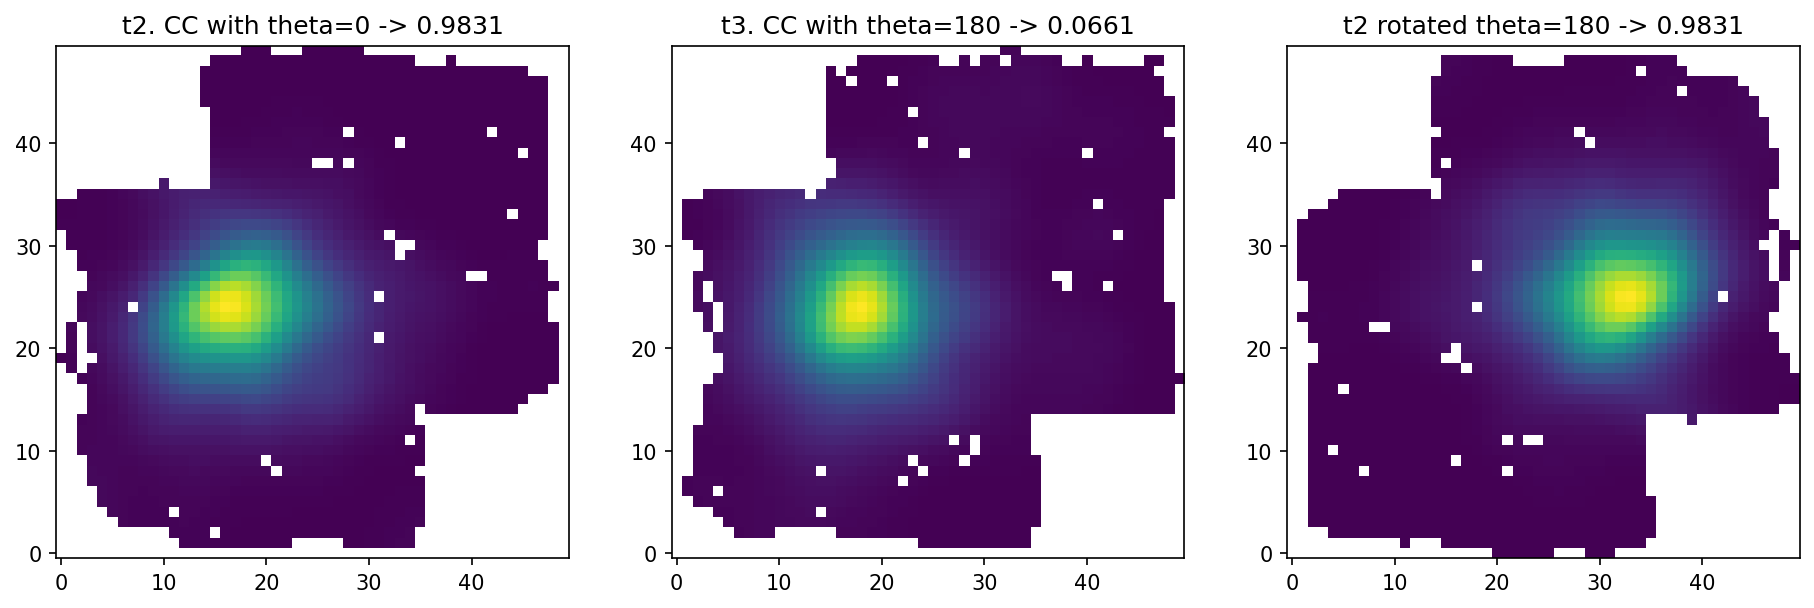

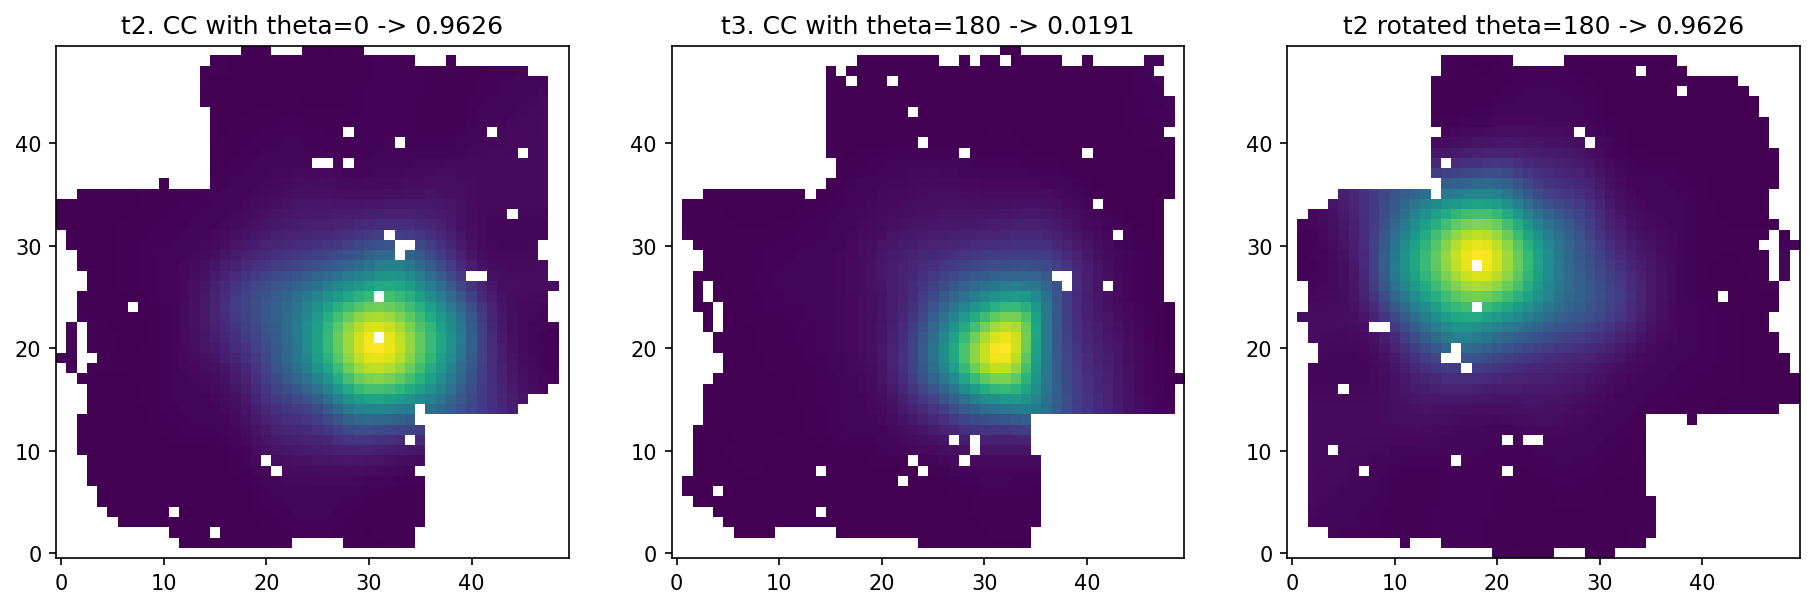

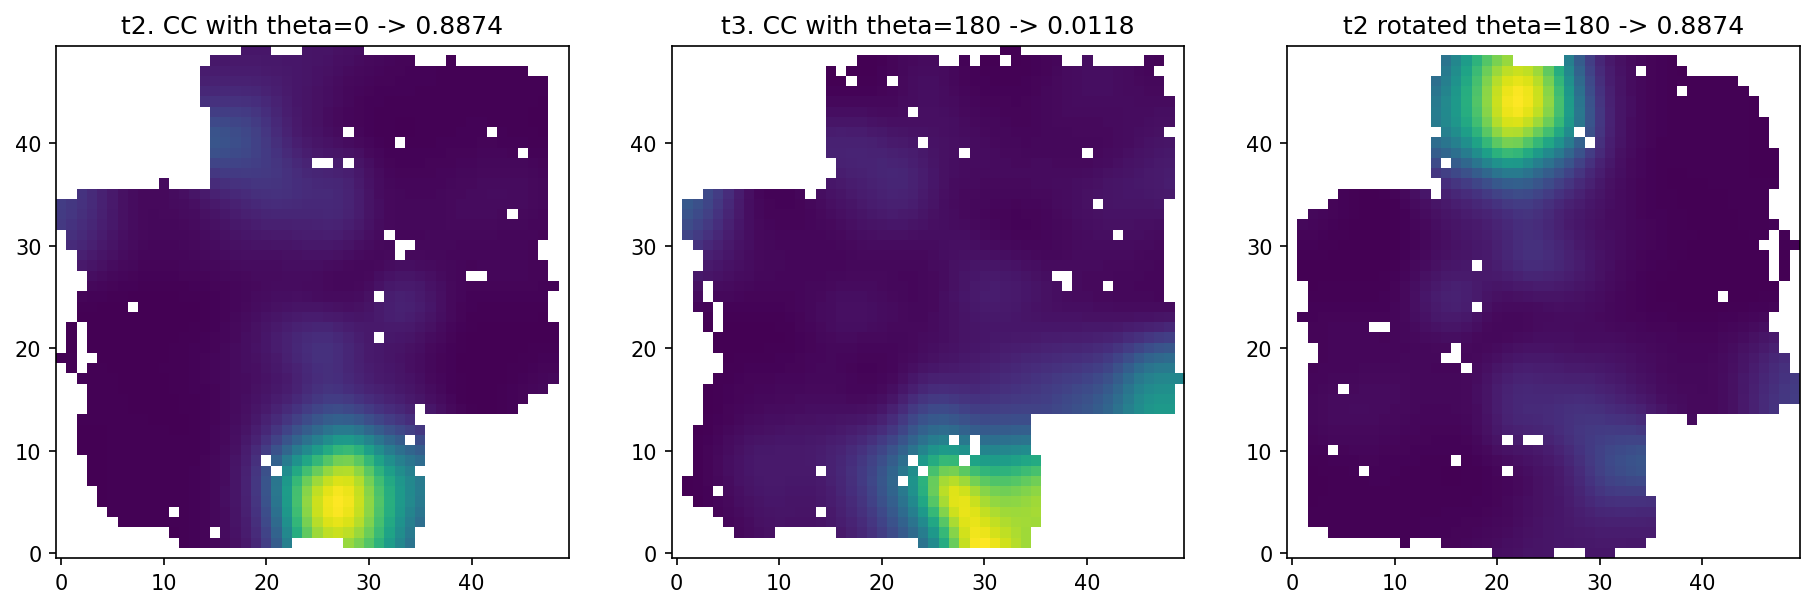

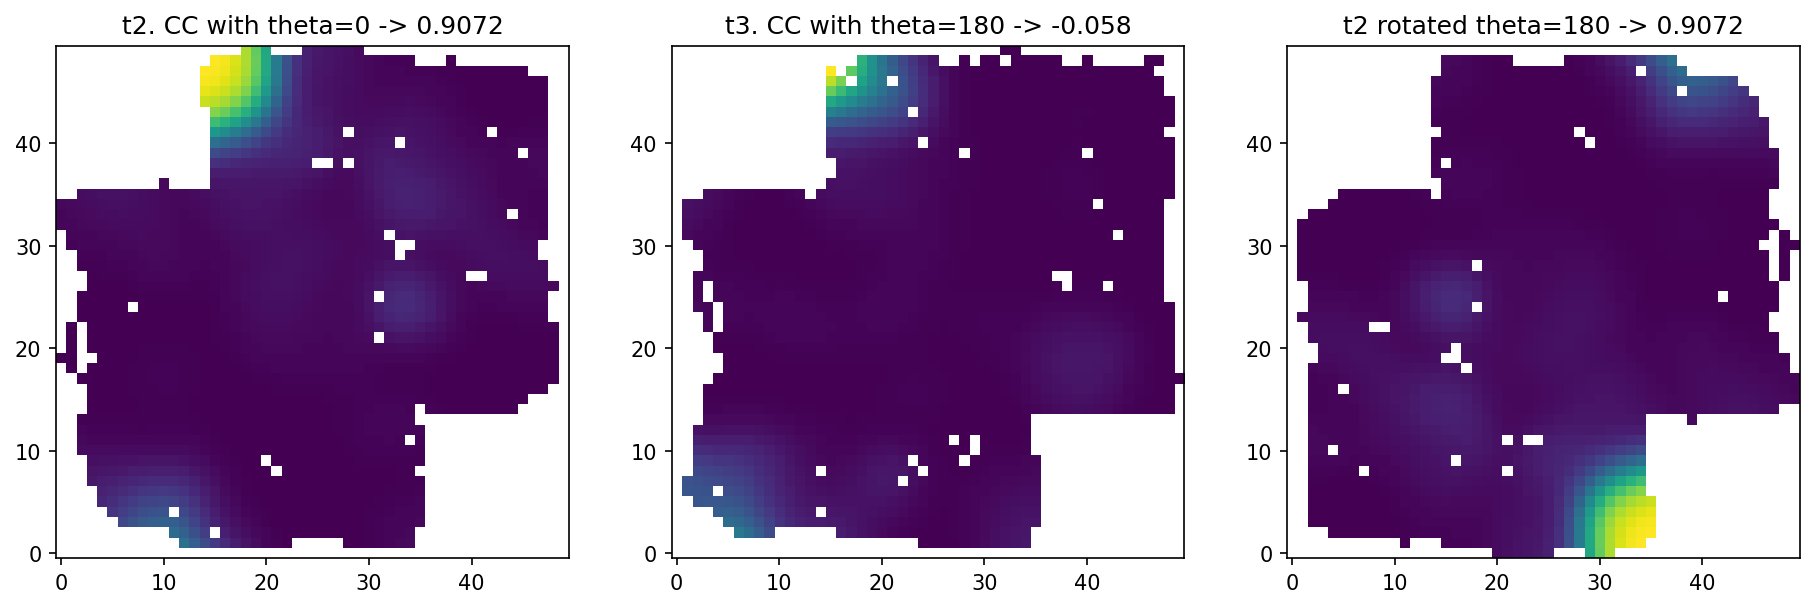

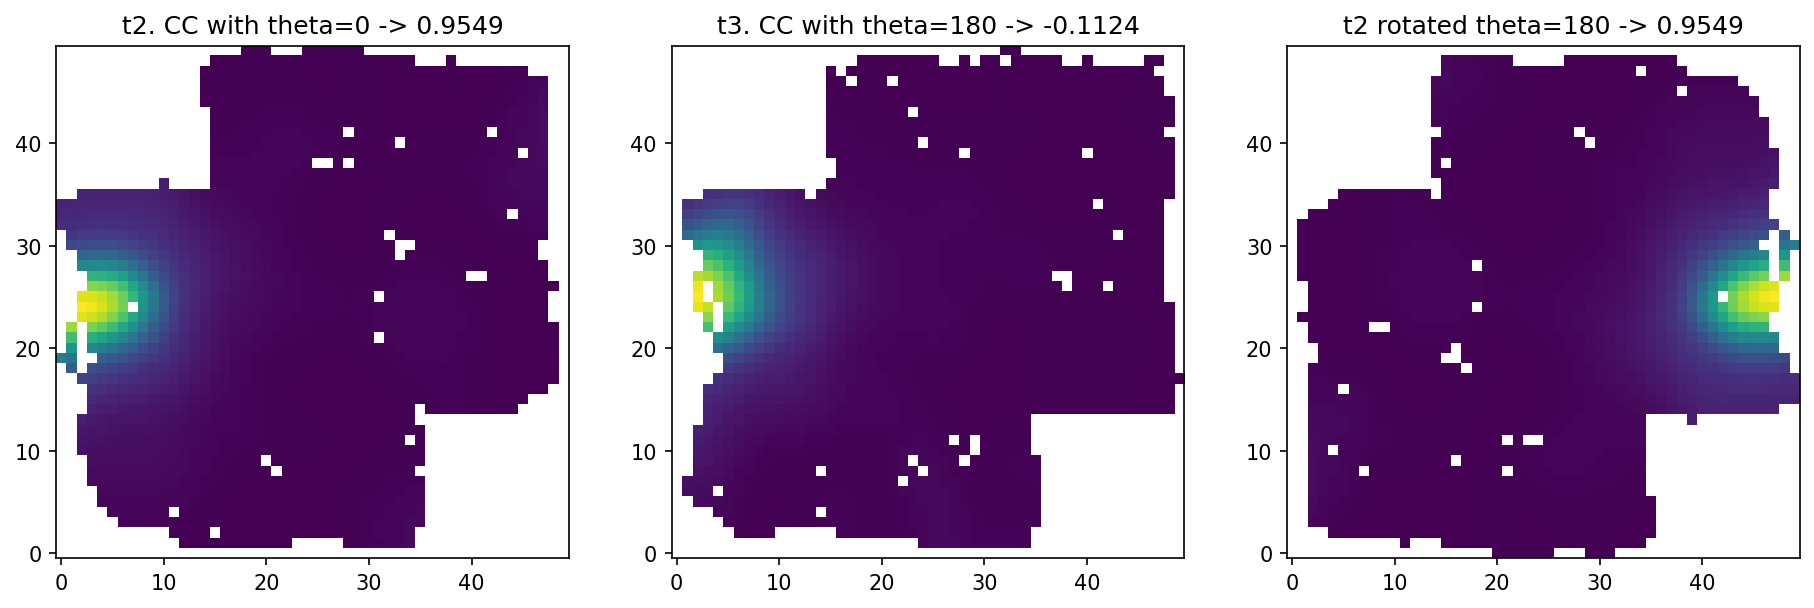

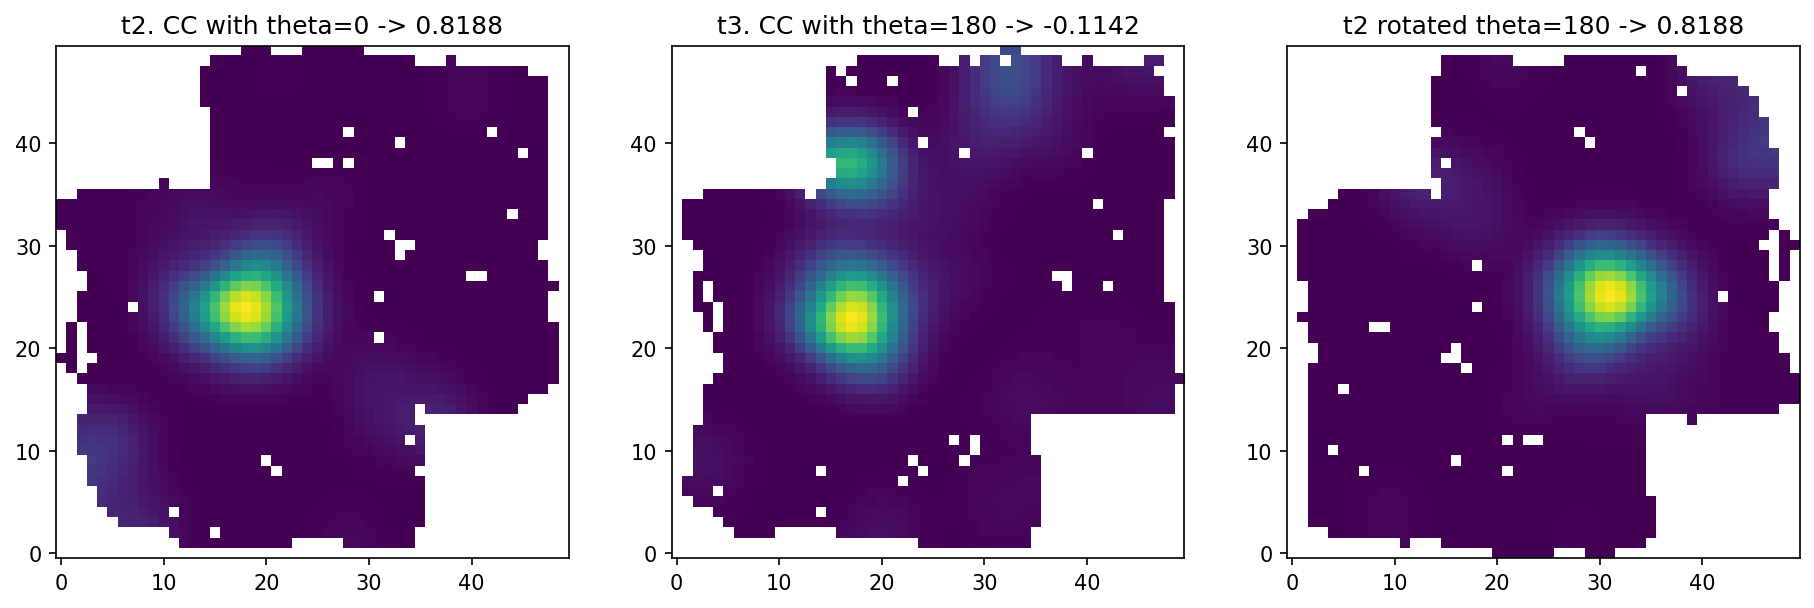

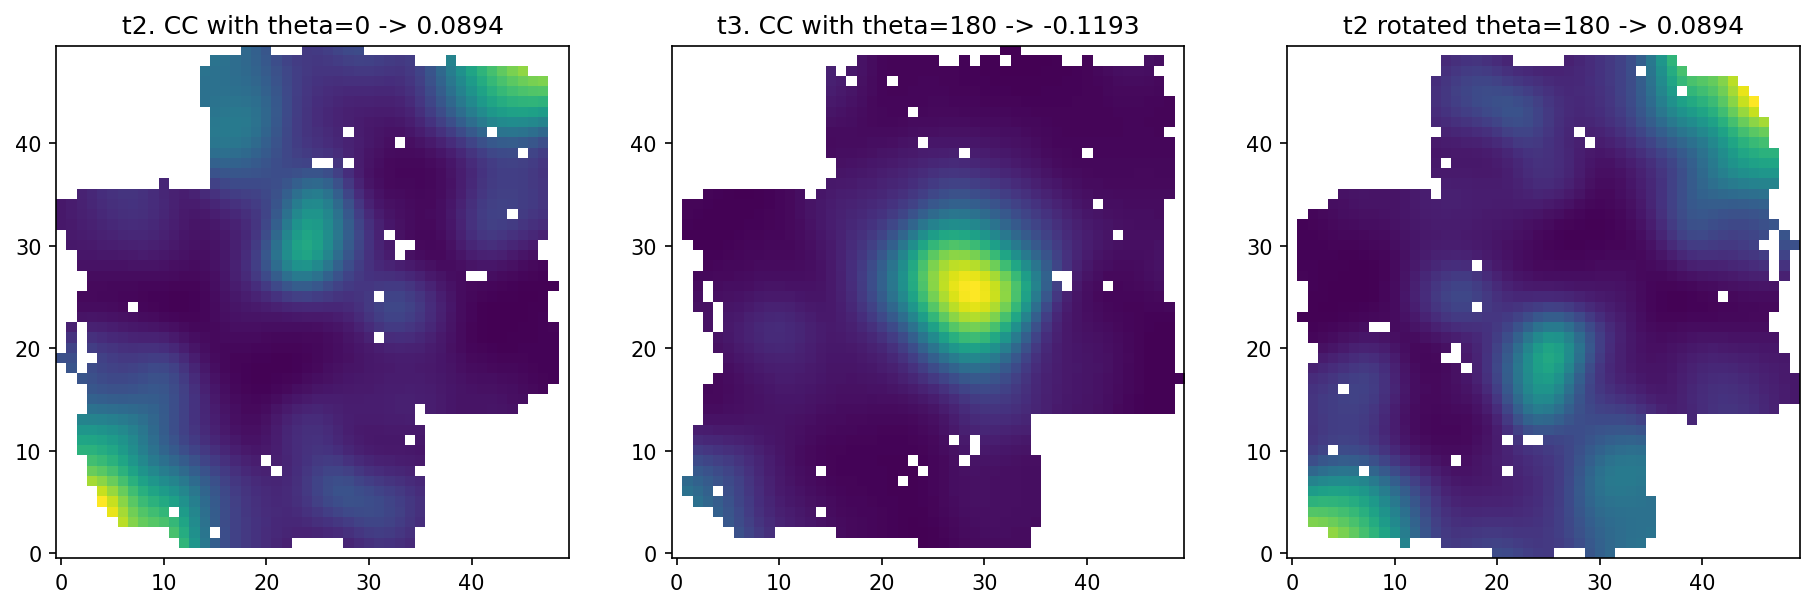

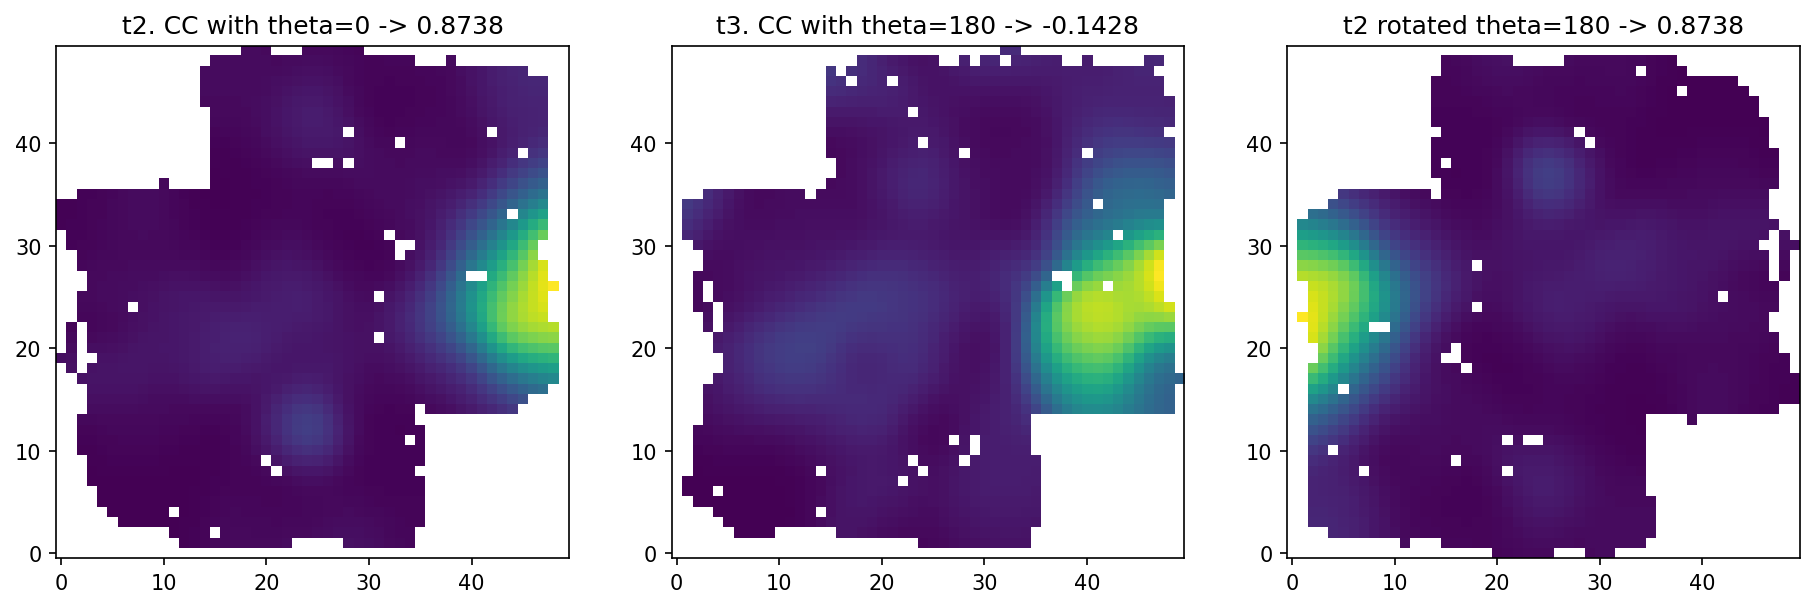

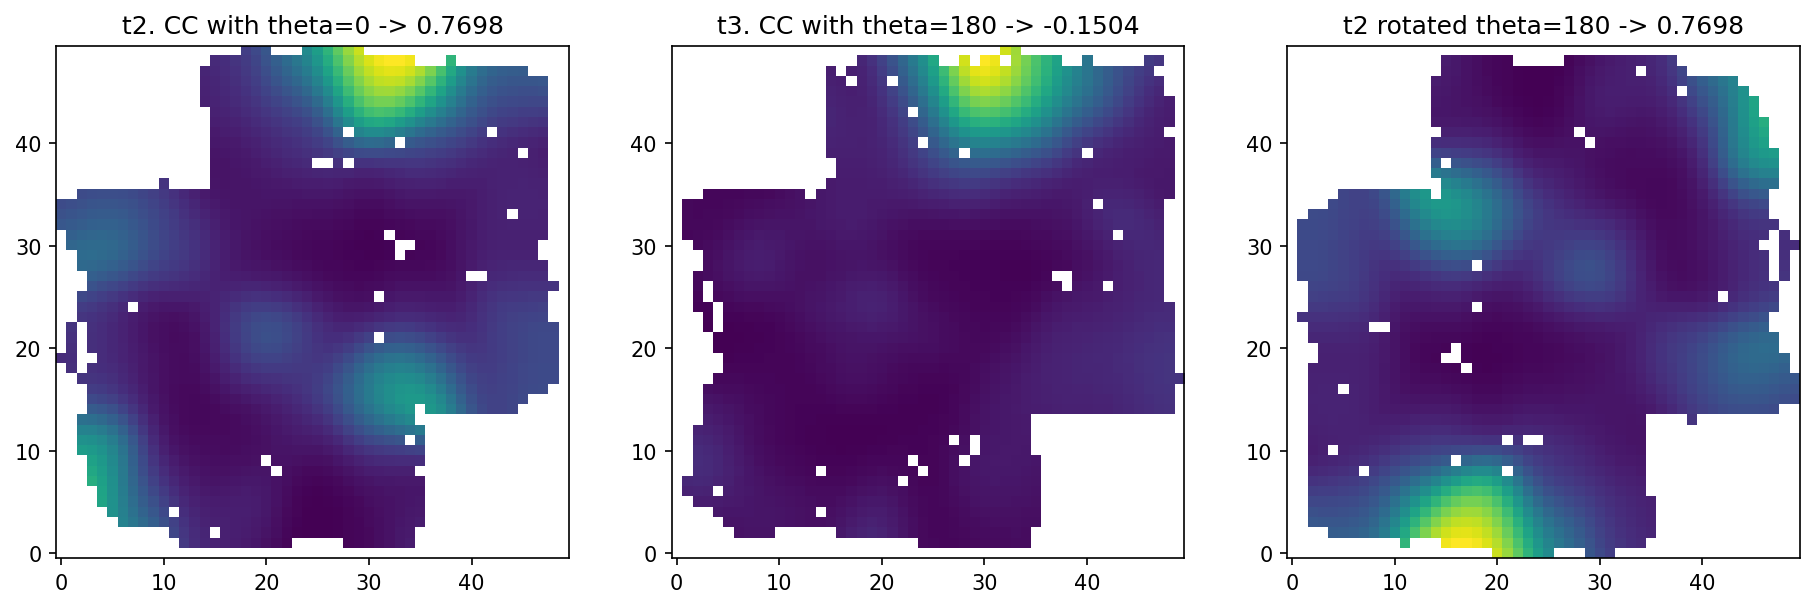

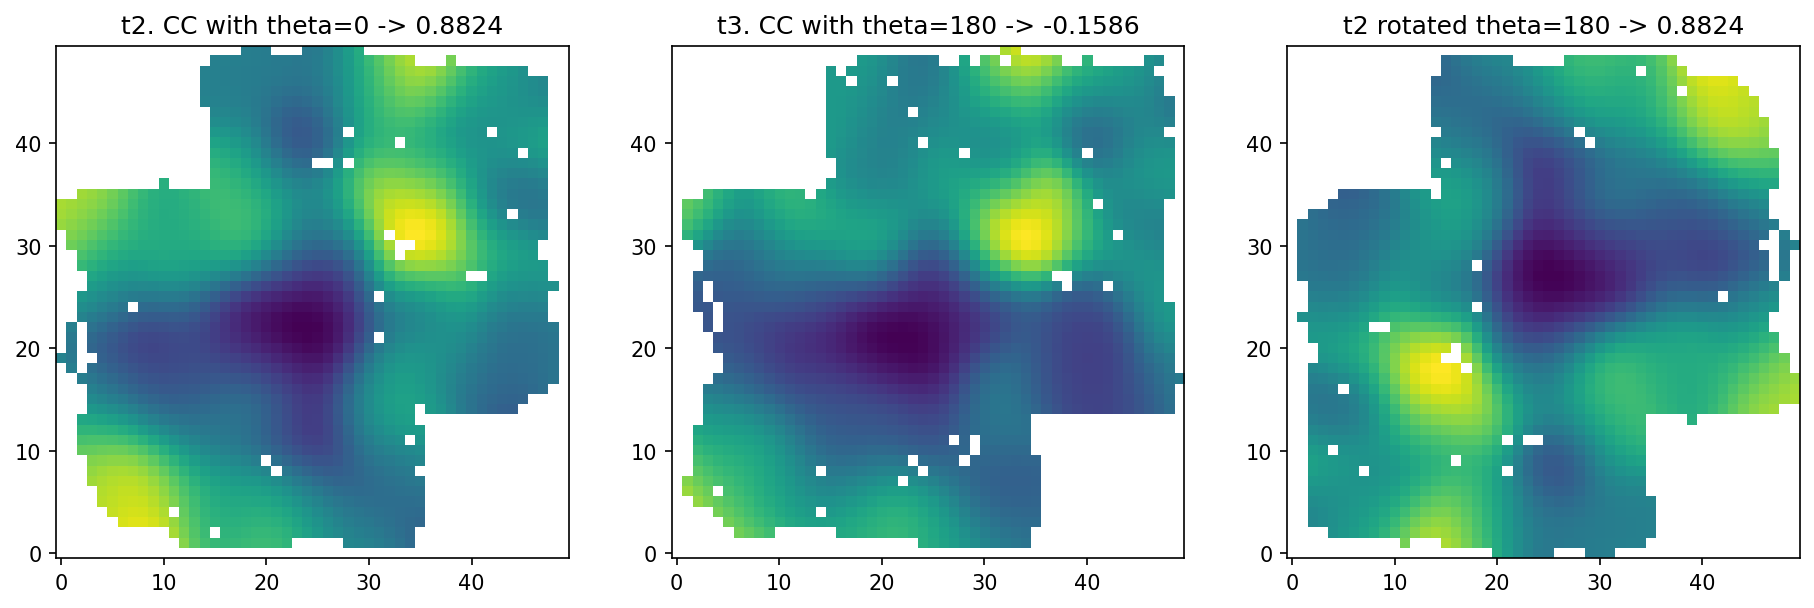

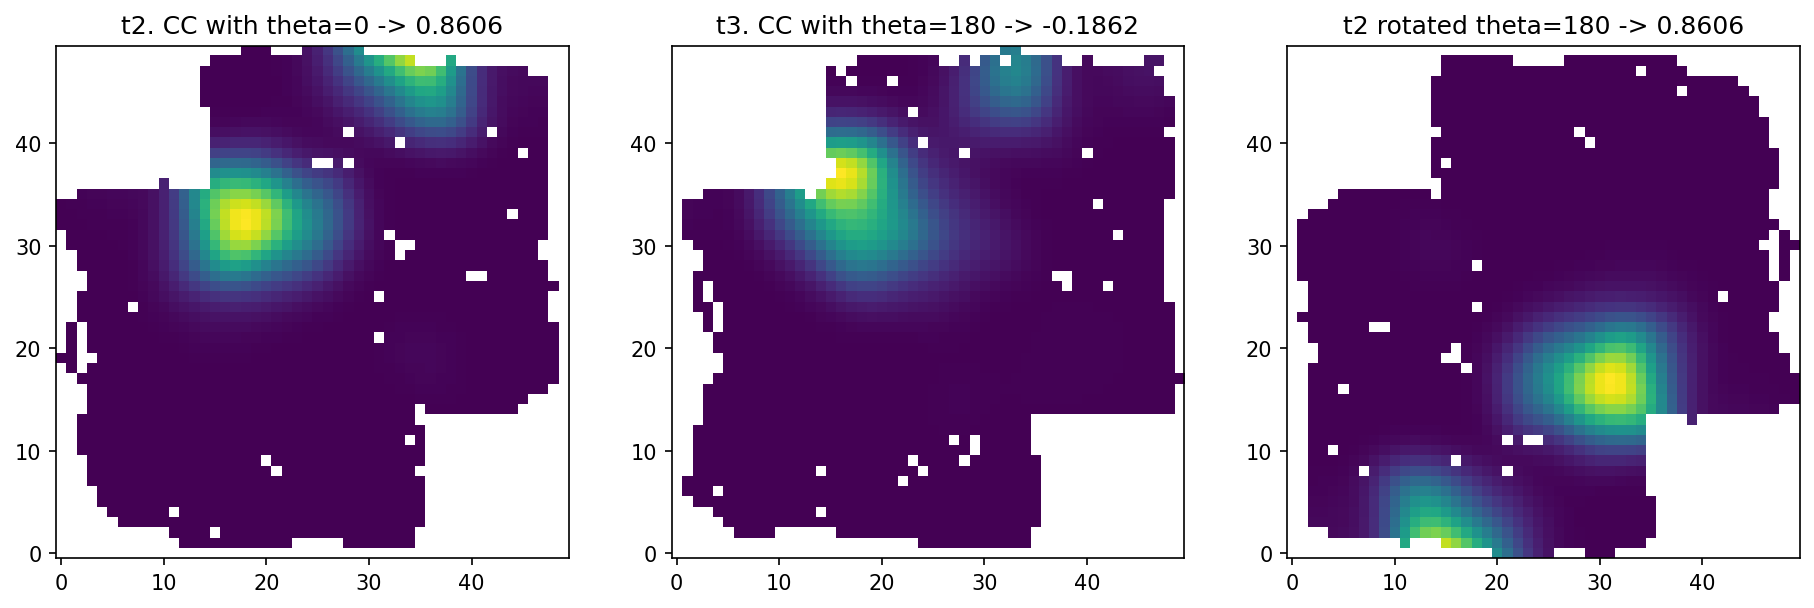

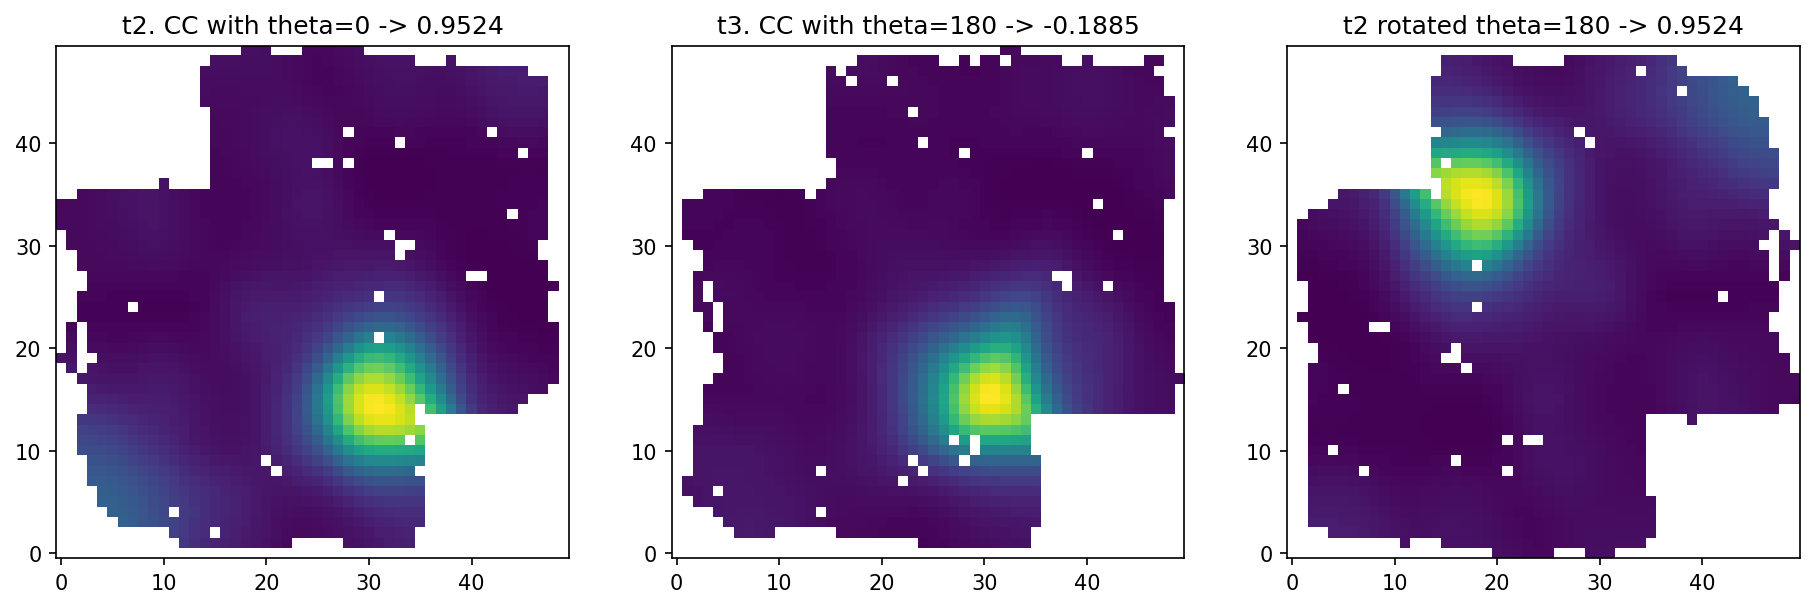

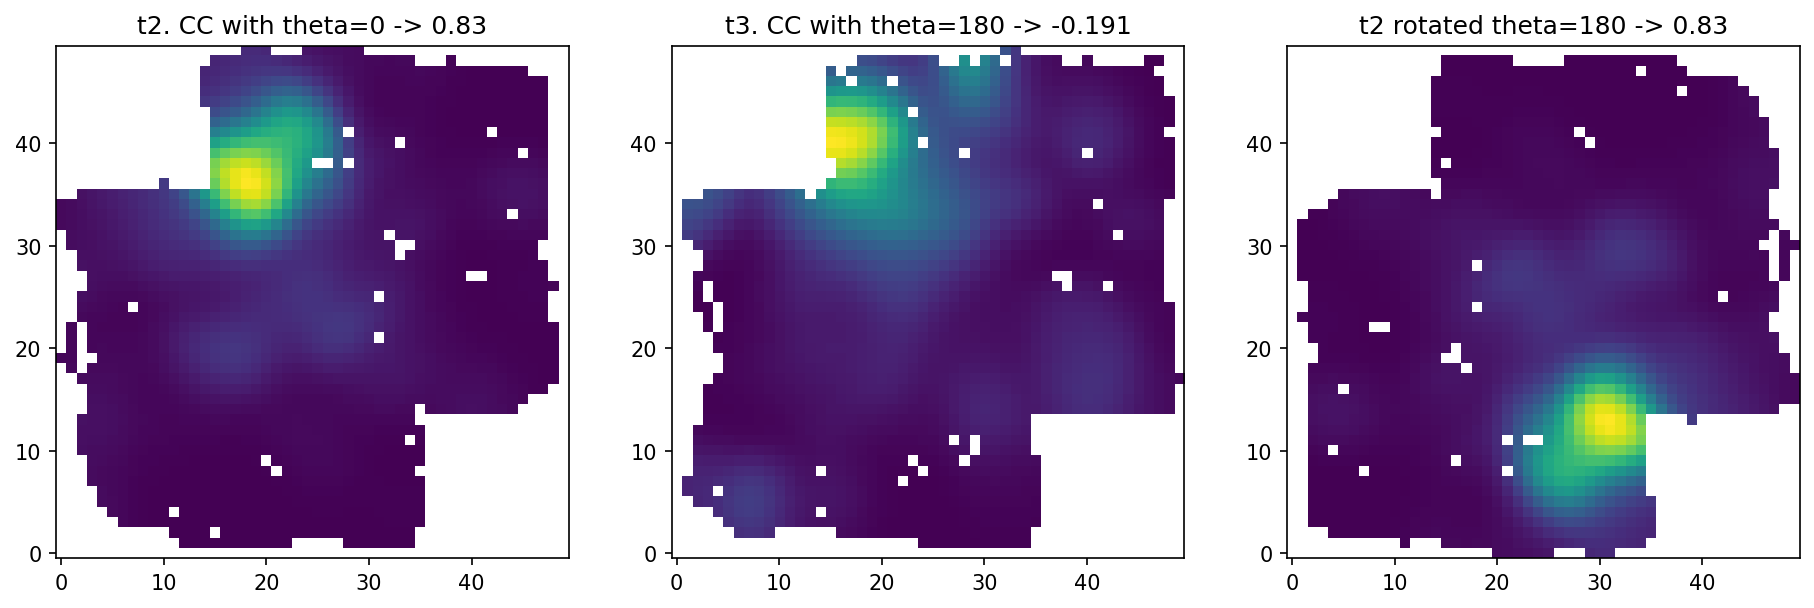

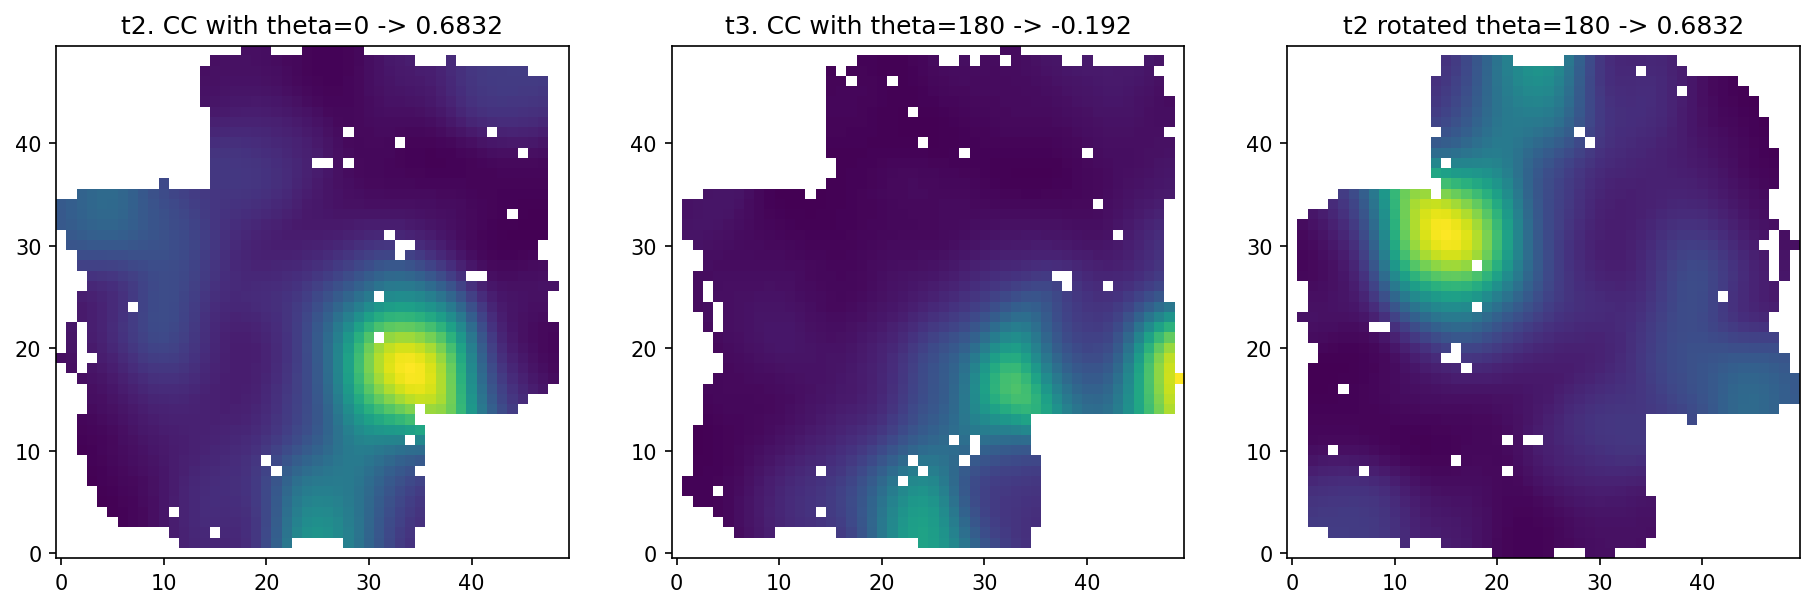

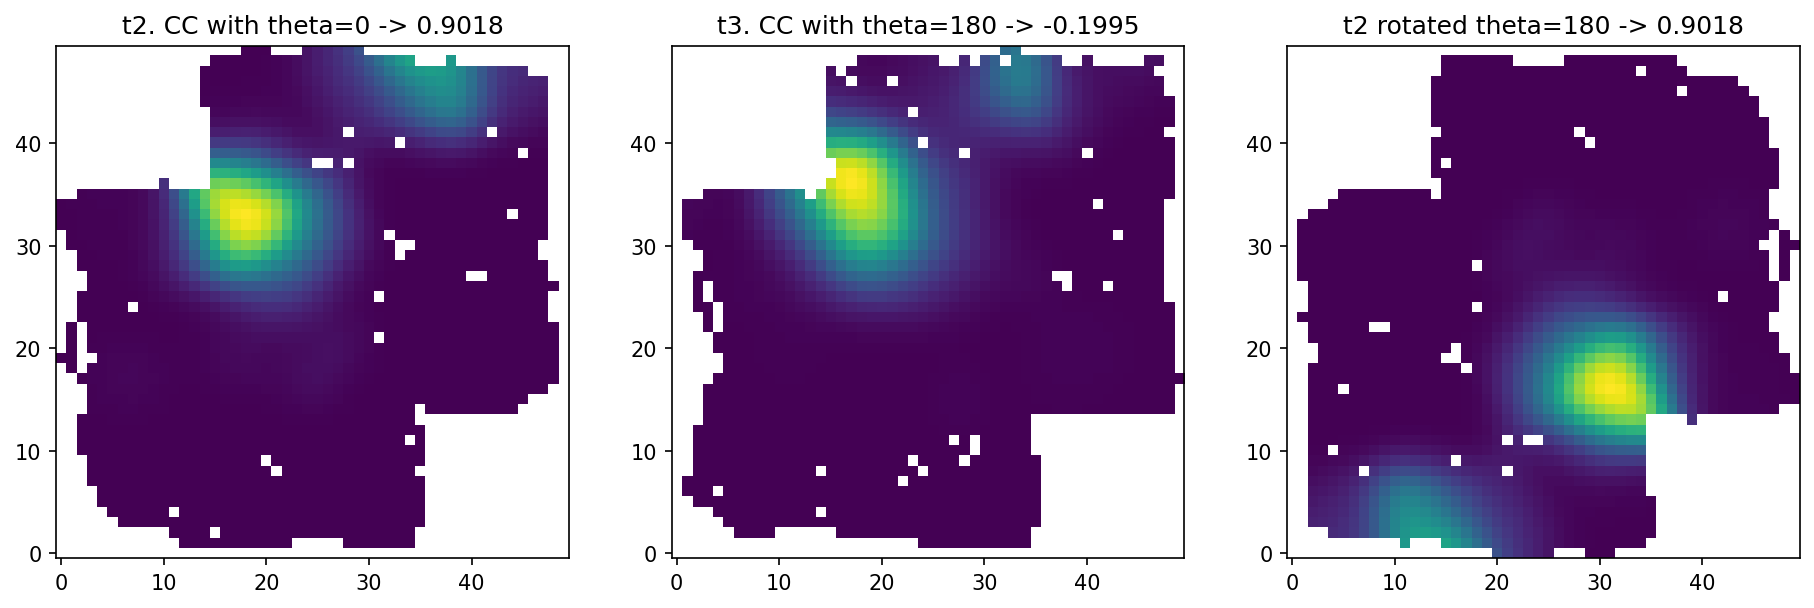

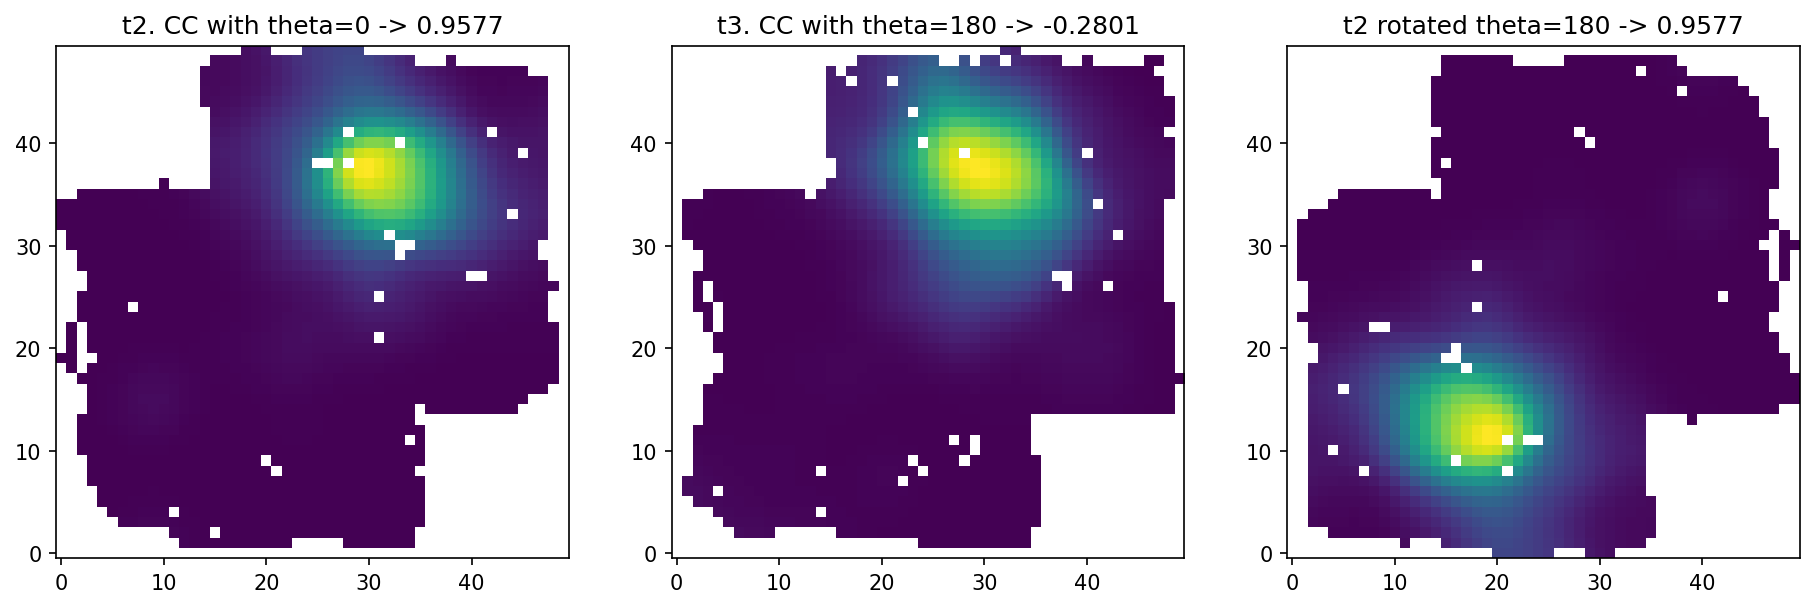

In [10]:
for idx in np.argsort(crosscorrelation['rot180'])[::-1]: # choose to sort on rotated or not
    action_id1, action_id2 = spikes1[idx].annotations["action_id"], spikes2[idx].annotations["action_id"]
    ratemap1 = ratemap_func(*tracking[action_id1].T[:3],spikes1[idx])
    ratemap2 = ratemap_func(*tracking[action_id2].T[:3],spikes2[idx])
    fig, ax = plt.subplots(ncols=3,figsize=(15,5))
    ax[0].imshow(ratemap1,origin='lower')
    ax[0].set_title(f'{trials[0]}. CC with theta=0 -> {round(crosscorrelation["rot0"][idx],4)}')
    ax[1].imshow(ratemap2,origin='lower')
    ax[1].set_title(f'{trials[1]}. CC with theta=180 -> {round(crosscorrelation["rot180"][idx],4)}')
    ax[2].imshow(ratemap1[::-1,::-1],origin='lower')
    ax[2].set_title(f'{trials[0]} rotated theta=180 -> {round(crosscorrelation["rot0"][idx],4)}')
    #fig.savefig('./plots/{}-visual-{}.pdf'.format(trials[0]+trials[1], spikes1[idx].annotations["unit_idnum"]))